In [31]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use GPU 0 only

# ---------------- Segment 1: Imports & Device ----------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from tqdm import tqdm
from collections import Counter
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [32]:
data_dir = "/kaggle/input/adni-dataset"

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


In [33]:
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
print("Classes:", full_dataset.classes)

# Train/val/test split
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size]
)

# Apply correct transforms for val/test
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
print("Class distribution in full dataset:", Counter(full_dataset.targets))

Classes: ['AD', 'CN', 'MCI']
Train: 8961, Val: 1920, Test: 1921
Class distribution in full dataset: Counter({0: 4370, 2: 4247, 1: 4185})


In [34]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

In [35]:
weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)

# Replace head
num_classes = len(full_dataset.classes)
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

# Freeze backbone first
for param in model.parameters():
    param.requires_grad = False
for param in model.heads.head.parameters():
    param.requires_grad = True

model = model.to(device)
print(model)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [36]:
targets = full_dataset.targets
class_counts = Counter(targets)
class_weights = [1.0 / class_counts[i] for i in range(num_classes)]
class_weights = torch.tensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.AdamW(model.heads.head.parameters(), lr=3e-5, weight_decay=0.01)
num_epochs_stage1 = 5
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs_stage1)

best_val_acc = 0.0

In [37]:
# ---------------- Segment 7: Training Loop Stage 1 ----------------
for epoch in range(num_epochs_stage1):
    model.train()
    running_loss = 0.0
    train_loader_pbar = tqdm(train_loader, desc=f"Stage1 Epoch {epoch+1}/{num_epochs_stage1} [Train]", leave=False)
    
    for imgs, labels in train_loader_pbar:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loader_pbar.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    val_loader_pbar = tqdm(val_loader, desc=f"Stage1 Epoch {epoch+1}/{num_epochs_stage1} [Val]", leave=False)

    with torch.no_grad():
        for imgs, labels in val_loader_pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_loss /= len(val_loader)
    print(f"Stage1 Epoch {epoch+1}/{num_epochs_stage1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "model_state": model.state_dict(),
            "class_to_idx": full_dataset.class_to_idx
        }, "best_vit_stage1.pth")

    scheduler.step()

Stage1 Epoch 1/5 | Train Loss: 1.0821 | Val Loss: 1.0555 | Val Acc: 0.4359


Stage1 Epoch 2/5 | Train Loss: 1.0403 | Val Loss: 1.0343 | Val Acc: 0.4651


Stage1 Epoch 3/5 | Train Loss: 1.0230 | Val Loss: 1.0216 | Val Acc: 0.4802


Stage1 Epoch 4/5 | Train Loss: 1.0149 | Val Loss: 1.0154 | Val Acc: 0.4948


Stage1 Epoch 5/5 | Train Loss: 1.0103 | Val Loss: 1.0139 | Val Acc: 0.4958


In [39]:
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

num_epochs_stage2 = 15   # ✅ define this here
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs_stage2)
best_val_acc_stage2 = best_val_acc

In [40]:
for epoch in range(num_epochs_stage2):
    model.train()
    running_loss = 0.0
    train_loader_pbar = tqdm(train_loader, desc=f"Stage2 Epoch {epoch+1}/{num_epochs_stage2} [Train]", leave=False)
    
    for imgs, labels in train_loader_pbar:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loader_pbar.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    val_loader_pbar = tqdm(val_loader, desc=f"Stage2 Epoch {epoch+1}/{num_epochs_stage2} [Val]", leave=False)

    with torch.no_grad():
        for imgs, labels in val_loader_pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_loss /= len(val_loader)
    print(f"Stage2 Epoch {epoch+1}/{num_epochs_stage2} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc_stage2:
        best_val_acc_stage2 = val_acc
        torch.save({
            "model_state": model.state_dict(),
            "class_to_idx": full_dataset.class_to_idx
        }, "best_vit_stage2.pth")

    scheduler.step()

Stage2 Epoch 1/15 | Train Loss: 0.8198 | Val Loss: 0.5558 | Val Acc: 0.7885


Stage2 Epoch 2/15 | Train Loss: 0.3730 | Val Loss: 0.3871 | Val Acc: 0.8490


Stage2 Epoch 3/15 | Train Loss: 0.1311 | Val Loss: 0.2845 | Val Acc: 0.8969


Stage2 Epoch 4/15 | Train Loss: 0.0464 | Val Loss: 0.2940 | Val Acc: 0.9036


Stage2 Epoch 5/15 | Train Loss: 0.0247 | Val Loss: 0.3739 | Val Acc: 0.8849


Stage2 Epoch 6/15 | Train Loss: 0.0222 | Val Loss: 0.2930 | Val Acc: 0.9057


Stage2 Epoch 7/15 | Train Loss: 0.0049 | Val Loss: 0.2936 | Val Acc: 0.9099


Stage2 Epoch 8/15 | Train Loss: 0.0015 | Val Loss: 0.2687 | Val Acc: 0.9245


Stage2 Epoch 9/15 | Train Loss: 0.0006 | Val Loss: 0.2711 | Val Acc: 0.9271


Stage2 Epoch 10/15 | Train Loss: 0.0005 | Val Loss: 0.2771 | Val Acc: 0.9292


Stage2 Epoch 11/15 | Train Loss: 0.0004 | Val Loss: 0.2828 | Val Acc: 0.9302


Stage2 Epoch 12/15 | Train Loss: 0.0003 | Val Loss: 0.2873 | Val Acc: 0.9292


Stage2 Epoch 13/15 | Train Loss: 0.0003 | Val Loss: 0.2908 | Val Acc: 0.9281


Stage2 Epoch 14/15 | Train Loss: 0.0003 | Val Loss: 0.2923 | Val Acc: 0.9292


Stage2 Epoch 15/15 | Train Loss: 0.0003 | Val Loss: 0.2927 | Val Acc: 0.9292


In [ ]:
model.save("vit_alzheimer.keras")   # Recommended new format


In [41]:
checkpoint = torch.load("best_vit_stage2.pth", map_location=device)
model.load_state_dict(checkpoint["model_state"])
idx_to_class = {v: k for k, v in checkpoint["class_to_idx"].items()}

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"✅ Test Accuracy: {correct/total:.4f}")

✅ Test Accuracy: 0.9407


In [55]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import torch

In [56]:
def predict_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        _, pred = torch.max(outputs, 1)

    pred_label = idx_to_class[pred.item()]

    # --- show image + prediction ---
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {pred_label}")
    plt.show()

    return pred_label

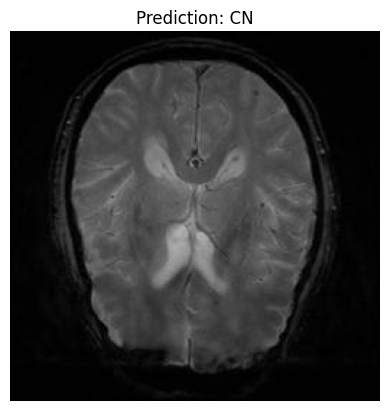

Prediction: CN


In [57]:
# Example usage
test_img = "/kaggle/input/adni-dataset/CN/1008.jpg"
print("Prediction:", predict_image(test_img))

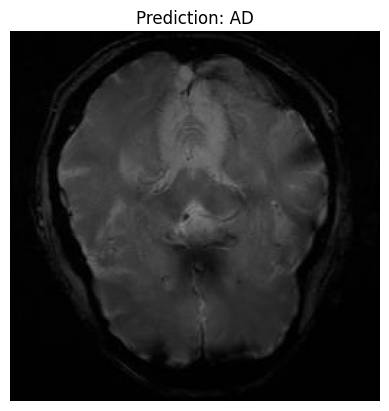

Prediction: AD


In [58]:
# Example usage
test_img = "/kaggle/input/adni-dataset/AD/1014.jpg"
print("Prediction:", predict_image(test_img))

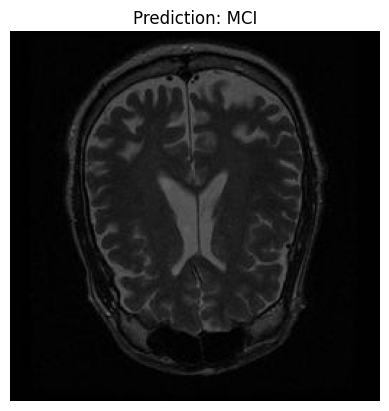

Prediction: MCI


In [59]:
# Example usage
test_img = "/kaggle/input/adni-dataset/MCI/1022.jpg"
print("Prediction:", predict_image(test_img))

In [43]:
def predict_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(img)
        _, pred = torch.max(outputs, 1)

    return idx_to_class[pred.item()]

# Example usage
test_img = "/kaggle/input/adni-dataset/AD/1003.jpg"
print("Prediction:", predict_image(test_img))

Prediction: AD
